In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 8.8 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import (
    FuncAnimation,
)

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



### Parâmetros da Rede Neural, Constantes do Problema e Pesos da Função de Perda

In [3]:
#Pontos de amostragem
SAMPLE_POINTS = 2000

#Condição Inicial e Contorno
T_START = 0
T_END = WIDTH = LENGTH = 1.0

#Constante de difusividade
ALPHA = 0.01

#Rede Neural
ARCHITECTURE = (
    [3] + [60] * 5 + [1]
)
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
LEARNING_RATE = 1e-3
ITERATIONS = 10000  # Número de épocas
OPTIMIZER = "adam"  # Otimizador
BATCH_SIZE = 32

# Pesos dos componentes da função de perda (!!!)
LOSS_WEIGHTS = [
    10, #pde
    1,
    1,
    1,
    1, #up
    10, #ic
]

### Equação Diferencial

In [4]:
def pde(X, T):
    dT_xx = dde.grad.hessian(T, X, i=0, j=0)
    dT_yy = dde.grad.hessian(T, X, i=1, j=1)

    dT_t = dde.grad.jacobian(T, X, j=2)

    return dT_t - ALPHA * (dT_xx + dT_yy)

### Condições de Contorno

In [5]:
def boundary_right(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, WIDTH)


def boundary_left(X, on_boundary):
    x, _, _ = X
    return on_boundary and np.isclose(x, 0)


def boundary_top(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, LENGTH)


def boundary_bottom(X, on_boundary):
    _, y, _ = X
    return on_boundary and np.isclose(y, 0)

### Condição inicial

In [6]:
def boundary_initial(X, on_initial):
    _, _, t = X
    return on_initial and np.isclose(t, 0)

# Função para inicializar o tempo da condição inicial
def init_func(X):
    t = np.zeros((len(X), 1))
    return t

In [7]:
#Função para inicializar a temperatura da condição de contorno superior como sendo 1
def constraint_top(X):
    return np.ones((len(X), 1))

#Função para inicializar o restante das temperaturas como sendo 0
def func_zero(X):
    return np.zeros(
        (len(X), 1)
    )

### Definindo geometrias e os contornos no Deepxde

In [8]:
geom = dde.geometry.Rectangle([0, 0], [WIDTH, LENGTH])
timedomain = dde.geometry.TimeDomain(0, T_END)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [9]:
bc_l = dde.DirichletBC(geomtime, func_zero, boundary_left)
bc_r = dde.DirichletBC(geomtime, func_zero, boundary_right)
bc_up = dde.DirichletBC(geomtime, constraint_top, boundary_top)
bc_low = dde.DirichletBC(geomtime, func_zero, boundary_bottom)
ic = dde.IC(geomtime, init_func, boundary_initial)

### Estabelecendo quais os dados a rede utilizará


In [10]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_low, bc_up, ic],
    num_domain=int(SAMPLE_POINTS),
    num_boundary=int(SAMPLE_POINTS / 4),
    num_initial=int(SAMPLE_POINTS / 2),
)

### Definição da Rede e treinamento

In [11]:
net = dde.maps.FNN(ARCHITECTURE, ACTIVATION, INITIALIZER)

# aplica na saída para pegar a temperatura em módulo
net.apply_output_transform(lambda _, y: abs(y))

model = dde.Model(data, net)
model.compile(OPTIMIZER, lr=LEARNING_RATE, loss_weights=LOSS_WEIGHTS)

Compiling model...
Building feed-forward neural network...
'build' took 0.137487 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.267976 s



In [12]:
losshistory, trainstate = model.train(
    iterations=ITERATIONS,
    batch_size=BATCH_SIZE,
)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.56e-02, 2.01e-02, 2.88e-03, 3.39e-03, 7.60e-01, 4.68e-02]    [7.56e-02, 2.01e-02, 2.88e-03, 3.39e-03, 7.60e-01, 4.68e-02]    []  
1000      [4.09e-03, 1.54e-02, 2.05e-02, 3.67e-05, 3.29e-02, 1.49e-02]    [4.09e-03, 1.54e-02, 2.05e-02, 3.67e-05, 3.29e-02, 1.49e-02]    []  
2000      [3.21e-03, 1.06e-02, 1.96e-02, 3.54e-05, 2.62e-02, 6.38e-03]    [3.21e-03, 1.06e-02, 1.96e-02, 3.54e-05, 2.62e-02, 6.38e-03]    []  
3000      [4.55e-03, 5.80e-03, 2.18e-02, 8.03e-06, 2.78e-02, 1.23e-02]    [4.55e-03, 5.80e-03, 2.18e-02, 8.03e-06, 2.78e-02, 1.23e-02]    []  
4000      [4.12e-03, 3.52e-03, 1.95e-02, 1.11e-06, 1.90e-02, 2.79e-03]    [4.12e-03, 3.52e-03, 1.95e-02, 1.11e-06, 1.90e-02, 2.79e-03]    []  
5000      [5.79e-03, 2.43e-03, 1.94e-02, 1.78e-06, 1.59e-02, 1.87e-03]    [5.79e-03, 2.43e-03, 1.94e-02, 1.78e-06, 1

In [13]:
model.compile("L-BFGS-B", loss_weights=LOSS_WEIGHTS)
losshistory, train_state = model.train(batch_size=BATCH_SIZE)

Compiling model...
'compile' took 0.466432 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [4.50e-03, 4.63e-04, 1.33e-02, 2.27e-06, 1.17e-02, 1.51e-03]    [4.50e-03, 4.63e-04, 1.33e-02, 2.27e-06, 1.17e-02, 1.51e-03]    []  
11000     [1.10e-03, 1.87e-04, 4.08e-03, 9.43e-07, 3.54e-03, 2.30e-04]    [1.10e-03, 1.87e-04, 4.08e-03, 9.43e-07, 3.54e-03, 2.30e-04]        
12000     [7.01e-04, 5.84e-05, 2.66e-03, 3.69e-07, 2.60e-03, 7.27e-05]    [7.01e-04, 5.84e-05, 2.66e-03, 3.69e-07, 2.60e-03, 7.27e-05]        
13000     [4.60e-04, 6.62e-05, 2.30e-03, 2.26e-07, 2.34e-03, 2.16e-05]    [4.60e-04, 6.62e-05, 2.30e-03, 2.26e-07, 2.34e-03, 2.16e-05]        
14000     [3.39e-04, 4.60e-05, 2.12e-03, 1.89e-07, 2.28e-03, 1.77e-05]    [3.39e-04, 4.60e-05, 2.12e-03, 1.89e-07, 2.28e-03, 1.77e-05]        
15000     [2.59e-04, 2.60e-05, 2.11e-03, 1.09e-07, 2.16e-03, 1.22e-05]

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


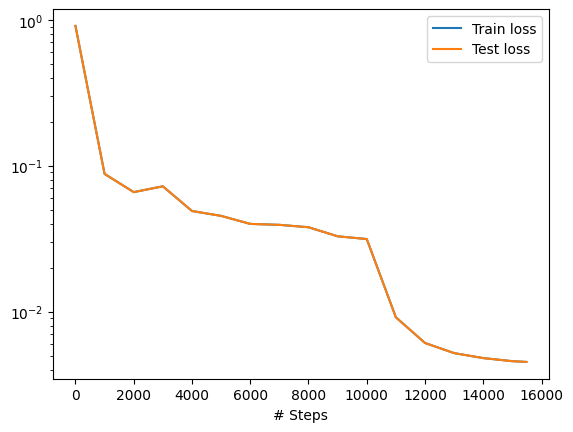

In [14]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)
plt.show()
plt.savefig("loss_history_plot_Heat2d")
plt.close()

### Animação

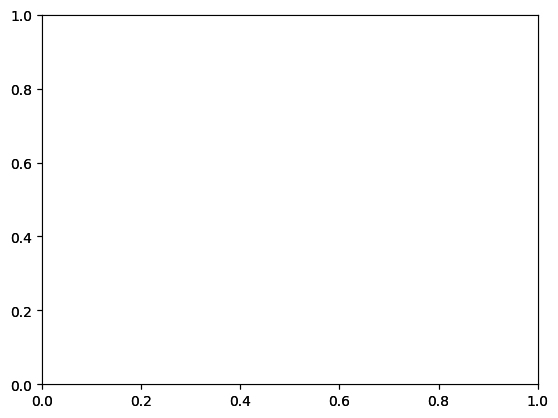

In [15]:
fig, ax = plt.subplots()
ax = fig.add_subplot(111)

nelx = 100  # Número de elementos em x
nely = 100  # Número de elementos em y
timesteps = 101

x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
t = np.linspace(0, 1, timesteps)

# Dados pra serem usados na predição
test_x, test_y, test_t = np.meshgrid(x, y, t)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_y), np.ravel(test_t))).T

In [16]:
# Predição da solução
predicted_solution = model.predict(test_domain)
predicted_solution = predicted_solution.reshape(
    test_x.shape
)

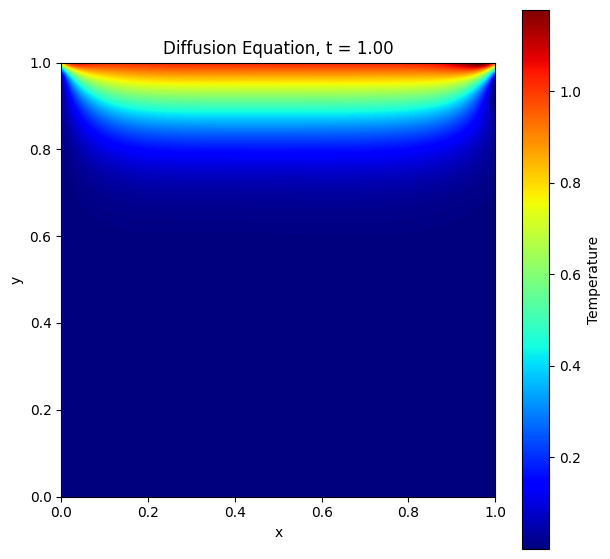

In [37]:
def animate_solution(data, filename, title, label, t_data):
    fig, ax = plt.subplots(figsize=(7, 7))

    # Cria a imagem inicial com a barra de cores
    im = ax.imshow(
        data[:, :, 0],
        origin="lower",
        cmap="jet",
        interpolation="bilinear",
        extent=[0, 1, 0, 1],
    )
    cb = plt.colorbar(im, ax=ax, label=label)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    # Atualiza os frames
    def updatefig(k):
        # Atualiza a imagem em si
        im.set_array(data[:, :, k])
        im.set_clim(
            vmin=data[:, :, k].min(), vmax=data[:, :, k].max()
        )  # Atualiza também as cores limitantes

        cb.update_normal(im)

        ax.set_title(f"{title}, t = {t_data[k]:.2f}")

        return [im]

    ani = animation.FuncAnimation(
        fig, updatefig, frames=range(data.shape[2]), interval=50, blit=True
    )
    ani.save(filename, writer="ffmpeg")


animate_solution(
    predicted_solution,
    f"pinn_heat2d_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation",
    "Temperature",
    t,
)

### Diferenças Finitas para comparação

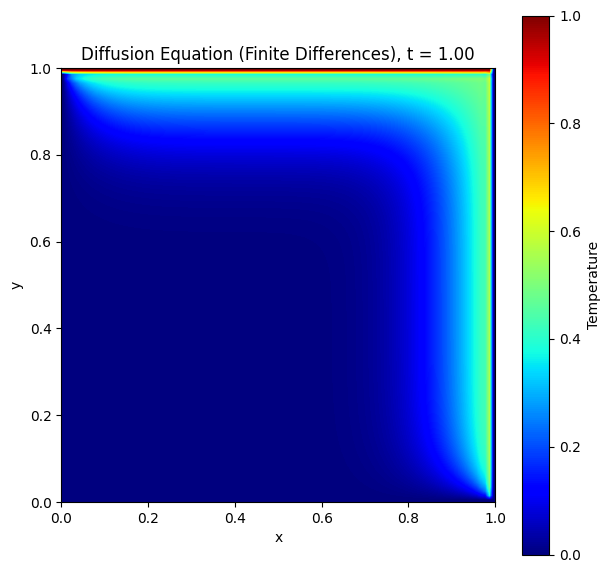

In [50]:
# Domain parameters
W = 1
H = 1
Nx = 101
Ny = 101
ALPHA = 0.01

# Discretization
dx = W / (Nx - 1)
dy = H / (Ny - 1)
dt = min(dx**2, dy**2) / (4 * ALPHA)
total_time = 1

# Mesh grid
x = np.linspace(0, W, Nx)
y = np.linspace(0, H, Ny)
X, Y = np.meshgrid(x, y)

# Initial condition
T = np.zeros((Nx, Ny))

# Time-stepping loop for animation
time = 0
frames = []
timesteps = int(total_time / dt) + 1

# Array para armazenar as soluções em cada passo de tempo
finite_difference_solution = np.zeros((Nx, Ny, timesteps))

def update(T):
    T_new = T.copy()
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            T_new[i, j] = T[i, j] + ALPHA * dt * (
                (T[i + 1, j] - 2 * T[i, j] + T[i - 1, j]) / dx**2
                + (T[i, j + 1] - 2 * T[i, j] + T[i, j - 1]) / dy**2
            )

    T_new[0, :] = 0
    T_new[:, 0] = 0
    T_new[:, -1] = 0
    T_new[-1, :] = 1 #up

    return T_new

for k in range(timesteps):
    T = update(T)
    finite_difference_solution[:, :, k] = T.copy()
    time += dt

# Usar a função animate_solution
animate_solution(
    finite_difference_solution,
    f"finite_difference_solution_alpha_{str(ALPHA)}.mp4",
    "Diffusion Equation (Finite Differences)",
    "Temperature",
    np.linspace(0, total_time, timesteps)
)